In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/Administrator/Desktop/misis_practice/Poem_classification - train_data.csv')
df.head(5)

,Genre,Poem
0,Music,NaN
1,Music,In the thick brushthey spend the...
2,Music,Storms are generous. ...
3,Music,—After Ana Mendieta Did you carry around the ...
4,Music,for Aja Sherrard at 20The portent may itself ...


<AxesSubplot:title={'center':'Count (target)'}>

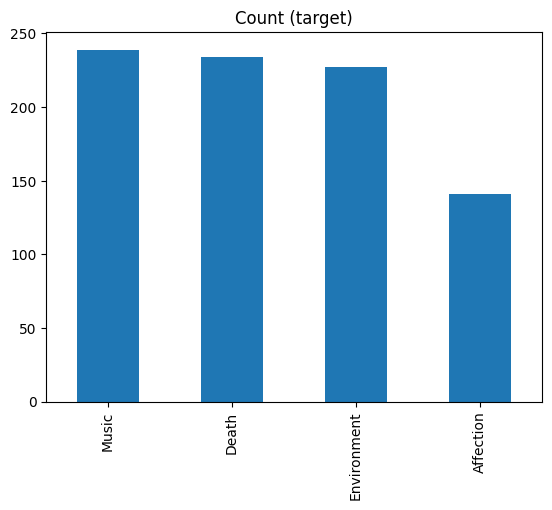

In [3]:
df['Genre'].value_counts().plot(kind='bar', title='Count (target)')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   841 non-null    object
 1   Poem    837 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB


In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 1 to 840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   837 non-null    object
 1   Poem    837 non-null    object
dtypes: object(2)
memory usage: 19.6+ KB


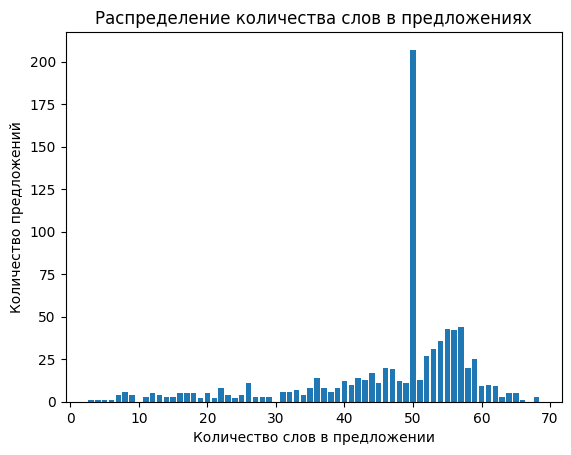

In [6]:
len_df = pd.DataFrame(df).copy()

# Добавляем столбец с количеством слов в предложении
len_df['word_count'] = df['Poem'].apply(lambda x: len(x.split()))

# Строим гистограмму
plt.hist(len_df['word_count'], bins=range(min(len_df['word_count']), max(len_df['word_count']) + 1, 1), rwidth=0.8, align='left')
plt.xlabel('Количество слов в предложении')
plt.ylabel('Количество предложений')
plt.title('Распределение количества слов в предложениях')
plt.show()

In [7]:
new_df = pd.DataFrame()
new_df['text'] = df['Poem']
new_df['label'] = df['Genre']
print(new_df.shape)

(837, 2)


In [8]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
import torch
from torch import nn
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.optim import Adam, SGD, RMSprop, Adagrad, Adadelta
from tqdm import tqdm

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
model_name = "distilbert-base-cased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name, truncation=True, do_lower_case=True)

In [11]:
labels = {}
for index, label in enumerate(new_df['label'].unique()):
    labels[label] = index
labels

{'Music': 0, 'Death': 1, 'Affection': 2, 'Environment': 3}

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = max_length, truncation=True,
                                return_tensors="pt") for text in df['text']]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [13]:
np.random.seed(112)
df_train, df_val = np.split(new_df.sample(frac=1, random_state=42),
                                     [int(.8*len(df))])

print(len(df_train),len(df_val))

669 168


In [14]:
arch1_train_acc = []
arch1_valid_acc = []

In [15]:
arch2_train_acc = []
arch2_valid_acc = []

In [16]:
arch3_train_acc = []
arch3_valid_acc = []

In [17]:
arch4_train_acc = []
arch4_valid_acc = []

Model 1 : arch 1

In [18]:
BATCH_SIZE=16
LEARNING_RATE=1e-6
EPOCHS=20
MAX_LEN = 64

In [19]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.dropout = nn.Dropout(0.12)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        last_hidden_state = self.bert(input_ids=input_id, attention_mask=mask).last_hidden_state
        pooled_output = last_hidden_state[:, 0]
        # linear_output = nn.functional.relu(self.linear(pooled_output))
        dropped_output = self.dropout(pooled_output)
        logits = self.classifier(dropped_output)
        final_layer = self.softmax(logits)

        return final_layer

In [20]:
model = BertClassifier()

In [21]:
def train(model, epochs):
    train, val = Dataset(df_train, MAX_LEN), Dataset(df_val, MAX_LEN)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)


    if use_cuda:
            print('on cuda')
            model = model.cuda()
            criterion = criterion.cuda()

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                model.zero_grad()

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc


                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            arch1_train_acc.append(total_acc_train / len(df_train))
            arch1_valid_acc.append(total_acc_val / len(df_val))

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} \
                | Train Accuracy: {total_acc_train / len(df_train): .3f} \
                | Val Loss: {total_loss_val / len(df_val): .3f} \
                | Val Accuracy: {total_acc_val / len(df_val): .3f}')

In [22]:
print('Adam, BS=16, lr=1e-6, ls=0.05')
print(LEARNING_RATE)
train(model, EPOCHS)

Adam, BS=16, lr=1e-6, ls=0.05
1e-06
on cuda


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 42/42 [00:03<00:00, 10.72it/s]


Epochs: 1 | Train Loss:  0.087                 | Train Accuracy:  0.277                 | Val Loss:  0.090                 | Val Accuracy:  0.333


100%|██████████| 42/42 [00:03<00:00, 11.38it/s]


Epochs: 2 | Train Loss:  0.086                 | Train Accuracy:  0.306                 | Val Loss:  0.090                 | Val Accuracy:  0.310


100%|██████████| 42/42 [00:04<00:00,  9.68it/s]


Epochs: 3 | Train Loss:  0.086                 | Train Accuracy:  0.318                 | Val Loss:  0.090                 | Val Accuracy:  0.304


100%|██████████| 42/42 [00:04<00:00,  9.66it/s]


Epochs: 4 | Train Loss:  0.086                 | Train Accuracy:  0.330                 | Val Loss:  0.090                 | Val Accuracy:  0.321


100%|██████████| 42/42 [00:04<00:00,  9.86it/s]


Epochs: 5 | Train Loss:  0.086                 | Train Accuracy:  0.399                 | Val Loss:  0.089                 | Val Accuracy:  0.381


100%|██████████| 42/42 [00:04<00:00, 10.25it/s]


Epochs: 6 | Train Loss:  0.085                 | Train Accuracy:  0.447                 | Val Loss:  0.089                 | Val Accuracy:  0.369


100%|██████████| 42/42 [00:04<00:00, 10.38it/s]


Epochs: 7 | Train Loss:  0.084                 | Train Accuracy:  0.448                 | Val Loss:  0.088                 | Val Accuracy:  0.339


100%|██████████| 42/42 [00:04<00:00, 10.31it/s]


Epochs: 8 | Train Loss:  0.083                 | Train Accuracy:  0.432                 | Val Loss:  0.088                 | Val Accuracy:  0.375


100%|██████████| 42/42 [00:04<00:00,  9.67it/s]


Epochs: 9 | Train Loss:  0.082                 | Train Accuracy:  0.471                 | Val Loss:  0.087                 | Val Accuracy:  0.375


100%|██████████| 42/42 [00:04<00:00,  9.36it/s]


Epochs: 10 | Train Loss:  0.080                 | Train Accuracy:  0.487                 | Val Loss:  0.086                 | Val Accuracy:  0.375


100%|██████████| 42/42 [00:04<00:00,  9.23it/s]


Epochs: 11 | Train Loss:  0.079                 | Train Accuracy:  0.513                 | Val Loss:  0.085                 | Val Accuracy:  0.387


100%|██████████| 42/42 [00:04<00:00,  9.41it/s]


Epochs: 12 | Train Loss:  0.078                 | Train Accuracy:  0.544                 | Val Loss:  0.085                 | Val Accuracy:  0.399


100%|██████████| 42/42 [00:04<00:00,  8.85it/s]


Epochs: 13 | Train Loss:  0.076                 | Train Accuracy:  0.567                 | Val Loss:  0.085                 | Val Accuracy:  0.393


100%|██████████| 42/42 [00:05<00:00,  8.19it/s]


Epochs: 14 | Train Loss:  0.075                 | Train Accuracy:  0.587                 | Val Loss:  0.085                 | Val Accuracy:  0.399


100%|██████████| 42/42 [00:04<00:00,  8.63it/s]


Epochs: 15 | Train Loss:  0.074                 | Train Accuracy:  0.596                 | Val Loss:  0.085                 | Val Accuracy:  0.417


100%|██████████| 42/42 [00:04<00:00,  8.72it/s]


Epochs: 16 | Train Loss:  0.073                 | Train Accuracy:  0.613                 | Val Loss:  0.085                 | Val Accuracy:  0.417


100%|██████████| 42/42 [00:04<00:00,  8.68it/s]


Epochs: 17 | Train Loss:  0.072                 | Train Accuracy:  0.629                 | Val Loss:  0.084                 | Val Accuracy:  0.411


100%|██████████| 42/42 [00:04<00:00,  8.52it/s]


Epochs: 18 | Train Loss:  0.070                 | Train Accuracy:  0.637                 | Val Loss:  0.085                 | Val Accuracy:  0.417


100%|██████████| 42/42 [00:05<00:00,  8.32it/s]


Epochs: 19 | Train Loss:  0.070                 | Train Accuracy:  0.664                 | Val Loss:  0.084                 | Val Accuracy:  0.411


100%|██████████| 42/42 [00:05<00:00,  8.34it/s]


Epochs: 20 | Train Loss:  0.069                 | Train Accuracy:  0.674                 | Val Loss:  0.084                 | Val Accuracy:  0.417


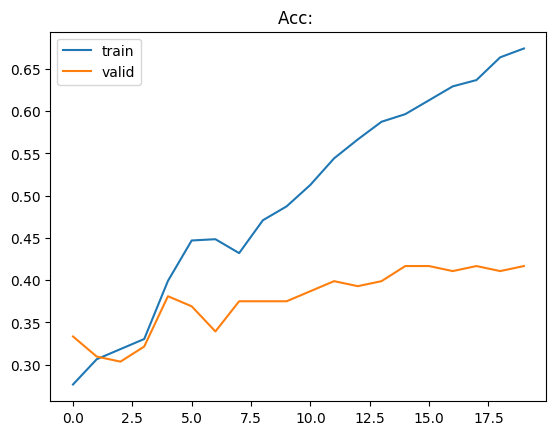

In [23]:
plt.title('Acc: ')
plt.plot(arch1_train_acc, label='train')
plt.plot(arch1_valid_acc, label='valid')
plt.legend()

Model 1 : arch 2

In [24]:
BATCH_SIZE=16
LEARNING_RATE=1e-6
EPOCHS=20
MAX_LEN = 64

In [25]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(model_name)
        self.act = nn.ReLU(0.2)
        self.linear_1 = nn.Linear(self.bert.config.hidden_size*2, 1024)
        self.linear_2 = nn.Linear(1024, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        last_hidden_state = self.bert(input_ids=input_id, attention_mask=mask).last_hidden_state
        mean_pooling_embeddings = torch.mean(last_hidden_state, 1)
        _, max_pooling_embeddings = torch.max(last_hidden_state, 1)
        mean_max_embeddings = torch.cat((mean_pooling_embeddings, max_pooling_embeddings), 1)
        logits = self.linear_1(mean_max_embeddings)
        logits = self.act(logits)
        logits = self.linear_2(logits)
        final_layer = self.softmax(logits)

        return final_layer

In [26]:
model = BertClassifier()

In [27]:
def train(model, epochs):
    train, val = Dataset(df_train, MAX_LEN), Dataset(df_val, MAX_LEN)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)


    if use_cuda:
            print('on cuda')
            model = model.cuda()
            criterion = criterion.cuda()

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                model.zero_grad()

                output = model(input_id, mask)
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc


                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            arch2_train_acc.append(total_acc_train / len(df_train))
            arch2_valid_acc.append(total_acc_val / len(df_val))

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} \
                | Train Accuracy: {total_acc_train / len(df_train): .3f} \
                | Val Loss: {total_loss_val / len(df_val): .3f} \
                | Val Accuracy: {total_acc_val / len(df_val): .3f}')

In [28]:
print(f'Adam, BS={BATCH_SIZE}, lr={LEARNING_RATE}, ls=0.05')
print(LEARNING_RATE)
train(model, EPOCHS)

Adam, BS=16, lr=1e-06, ls=0.05
1e-06


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


on cuda


100%|██████████| 42/42 [00:05<00:00,  8.38it/s]


Epochs: 1 | Train Loss:  0.092                 | Train Accuracy:  0.239                 | Val Loss:  0.093                 | Val Accuracy:  0.268


100%|██████████| 42/42 [00:04<00:00,  9.16it/s]


Epochs: 2 | Train Loss:  0.090                 | Train Accuracy:  0.266                 | Val Loss:  0.093                 | Val Accuracy:  0.274


100%|██████████| 42/42 [00:04<00:00,  8.97it/s]


Epochs: 3 | Train Loss:  0.090                 | Train Accuracy:  0.280                 | Val Loss:  0.093                 | Val Accuracy:  0.286


100%|██████████| 42/42 [00:04<00:00,  8.54it/s]


Epochs: 4 | Train Loss:  0.089                 | Train Accuracy:  0.281                 | Val Loss:  0.093                 | Val Accuracy:  0.286


100%|██████████| 42/42 [00:04<00:00,  8.63it/s]


Epochs: 5 | Train Loss:  0.089                 | Train Accuracy:  0.294                 | Val Loss:  0.094                 | Val Accuracy:  0.250


100%|██████████| 42/42 [00:05<00:00,  8.00it/s]


Epochs: 6 | Train Loss:  0.089                 | Train Accuracy:  0.297                 | Val Loss:  0.094                 | Val Accuracy:  0.262


100%|██████████| 42/42 [00:05<00:00,  7.88it/s]


Epochs: 7 | Train Loss:  0.089                 | Train Accuracy:  0.291                 | Val Loss:  0.093                 | Val Accuracy:  0.268


100%|██████████| 42/42 [00:05<00:00,  7.86it/s]


Epochs: 8 | Train Loss:  0.089                 | Train Accuracy:  0.290                 | Val Loss:  0.093                 | Val Accuracy:  0.286


100%|██████████| 42/42 [00:05<00:00,  7.95it/s]


Epochs: 9 | Train Loss:  0.089                 | Train Accuracy:  0.297                 | Val Loss:  0.092                 | Val Accuracy:  0.298


100%|██████████| 42/42 [00:05<00:00,  7.41it/s]


Epochs: 10 | Train Loss:  0.089                 | Train Accuracy:  0.296                 | Val Loss:  0.093                 | Val Accuracy:  0.292


100%|██████████| 42/42 [00:06<00:00,  6.90it/s]


Epochs: 11 | Train Loss:  0.088                 | Train Accuracy:  0.312                 | Val Loss:  0.093                 | Val Accuracy:  0.310


100%|██████████| 42/42 [00:06<00:00,  6.74it/s]


Epochs: 12 | Train Loss:  0.088                 | Train Accuracy:  0.303                 | Val Loss:  0.094                 | Val Accuracy:  0.244


100%|██████████| 42/42 [00:06<00:00,  6.70it/s]


Epochs: 13 | Train Loss:  0.088                 | Train Accuracy:  0.305                 | Val Loss:  0.094                 | Val Accuracy:  0.244


100%|██████████| 42/42 [00:06<00:00,  6.83it/s]


Epochs: 14 | Train Loss:  0.088                 | Train Accuracy:  0.309                 | Val Loss:  0.093                 | Val Accuracy:  0.274


100%|██████████| 42/42 [00:05<00:00,  7.44it/s]


Epochs: 15 | Train Loss:  0.088                 | Train Accuracy:  0.318                 | Val Loss:  0.092                 | Val Accuracy:  0.298


100%|██████████| 42/42 [00:06<00:00,  6.82it/s]


Epochs: 16 | Train Loss:  0.086                 | Train Accuracy:  0.344                 | Val Loss:  0.091                 | Val Accuracy:  0.310


100%|██████████| 42/42 [00:06<00:00,  6.76it/s]


Epochs: 17 | Train Loss:  0.085                 | Train Accuracy:  0.353                 | Val Loss:  0.092                 | Val Accuracy:  0.315


100%|██████████| 42/42 [00:06<00:00,  6.76it/s]


Epochs: 18 | Train Loss:  0.084                 | Train Accuracy:  0.378                 | Val Loss:  0.092                 | Val Accuracy:  0.304


100%|██████████| 42/42 [00:06<00:00,  6.78it/s]


Epochs: 19 | Train Loss:  0.083                 | Train Accuracy:  0.395                 | Val Loss:  0.091                 | Val Accuracy:  0.310


100%|██████████| 42/42 [00:06<00:00,  6.73it/s]


Epochs: 20 | Train Loss:  0.083                 | Train Accuracy:  0.387                 | Val Loss:  0.092                 | Val Accuracy:  0.310


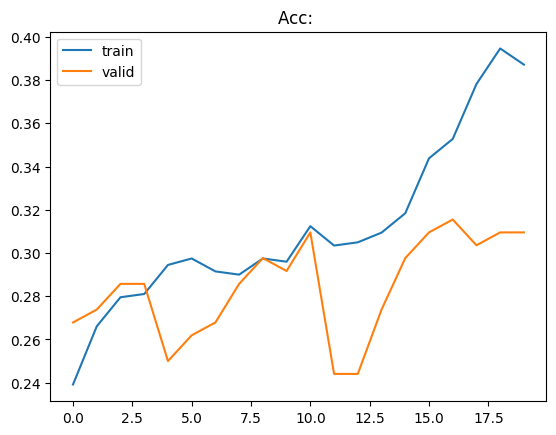

In [29]:
plt.title('Acc: ')
plt.plot(arch2_train_acc, label='train')
plt.plot(arch2_valid_acc, label='valid')
plt.legend()

Model 2 : arch 1

In [60]:
from transformers import RobertaTokenizer, RobertaModel

In [61]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name, truncation=True, do_lower_case=True, return_tensors='pt')

In [62]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = max_length, truncation=True,
                                return_tensors="pt") for text in df['text']]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [63]:
np.random.seed(112)
df_train, df_val = np.split(new_df.sample(frac=1, random_state=42),
                                     [int(.8*len(df))])

print(len(df_train),len(df_val))

669 168


In [64]:
BATCH_SIZE=16
LEARNING_RATE=1e-6
EPOCHS=20
MAX_LEN = 64

In [65]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = RobertaModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.dropout = nn.Dropout(0.12)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        last_hidden_state = self.bert(input_ids=input_id, attention_mask=mask).last_hidden_state
        pooled_output = last_hidden_state[:, 0]
        # linear_output = nn.functional.relu(self.linear(pooled_output))
        dropped_output = self.dropout(pooled_output)
        logits = self.classifier(dropped_output)
        final_layer = self.softmax(logits)

        return final_layer

In [66]:
model = BertClassifier()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
def train(model, epochs):
    train, val = Dataset(df_train, MAX_LEN), Dataset(df_val, MAX_LEN)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)


    if use_cuda:
            print('on cuda')
            model = model.cuda()
            criterion = criterion.cuda()

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                model.zero_grad()

                output = model(input_id, mask)
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc


                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            arch3_train_acc.append(total_acc_train / len(df_train))
            arch3_valid_acc.append(total_acc_val / len(df_val))

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} \
                | Train Accuracy: {total_acc_train / len(df_train): .3f} \
                | Val Loss: {total_loss_val / len(df_val): .3f} \
                | Val Accuracy: {total_acc_val / len(df_val): .3f}')

In [68]:
print(f'Adam, BS={BATCH_SIZE}, lr={LEARNING_RATE}, ls=0.05')
print(LEARNING_RATE)
train(model, EPOCHS)

Adam, BS=16, lr=1e-06, ls=0.05
1e-06
on cuda


100%|██████████| 42/42 [00:52<00:00,  1.26s/it]


Epochs: 1 | Train Loss:  0.087                 | Train Accuracy:  0.278                 | Val Loss:  0.091                 | Val Accuracy:  0.262


100%|██████████| 42/42 [00:52<00:00,  1.26s/it]


Epochs: 2 | Train Loss:  0.087                 | Train Accuracy:  0.281                 | Val Loss:  0.091                 | Val Accuracy:  0.250


100%|██████████| 42/42 [00:52<00:00,  1.25s/it]


Epochs: 3 | Train Loss:  0.087                 | Train Accuracy:  0.281                 | Val Loss:  0.091                 | Val Accuracy:  0.274


100%|██████████| 42/42 [00:52<00:00,  1.24s/it]


Epochs: 4 | Train Loss:  0.087                 | Train Accuracy:  0.286                 | Val Loss:  0.090                 | Val Accuracy:  0.286


100%|██████████| 42/42 [00:52<00:00,  1.25s/it]


Epochs: 5 | Train Loss:  0.086                 | Train Accuracy:  0.293                 | Val Loss:  0.090                 | Val Accuracy:  0.286


100%|██████████| 42/42 [00:52<00:00,  1.26s/it]


Epochs: 6 | Train Loss:  0.086                 | Train Accuracy:  0.324                 | Val Loss:  0.089                 | Val Accuracy:  0.381


100%|██████████| 42/42 [00:52<00:00,  1.25s/it]


Epochs: 7 | Train Loss:  0.083                 | Train Accuracy:  0.436                 | Val Loss:  0.086                 | Val Accuracy:  0.417


100%|██████████| 42/42 [00:51<00:00,  1.23s/it]


Epochs: 8 | Train Loss:  0.080                 | Train Accuracy:  0.460                 | Val Loss:  0.085                 | Val Accuracy:  0.405


100%|██████████| 42/42 [00:52<00:00,  1.24s/it]


Epochs: 9 | Train Loss:  0.078                 | Train Accuracy:  0.490                 | Val Loss:  0.085                 | Val Accuracy:  0.417


100%|██████████| 42/42 [00:52<00:00,  1.26s/it]


Epochs: 10 | Train Loss:  0.076                 | Train Accuracy:  0.553                 | Val Loss:  0.085                 | Val Accuracy:  0.429


100%|██████████| 42/42 [00:53<00:00,  1.27s/it]


Epochs: 11 | Train Loss:  0.074                 | Train Accuracy:  0.571                 | Val Loss:  0.084                 | Val Accuracy:  0.411


100%|██████████| 42/42 [00:53<00:00,  1.27s/it]


Epochs: 12 | Train Loss:  0.073                 | Train Accuracy:  0.602                 | Val Loss:  0.084                 | Val Accuracy:  0.417


100%|██████████| 42/42 [00:52<00:00,  1.26s/it]


Epochs: 13 | Train Loss:  0.072                 | Train Accuracy:  0.622                 | Val Loss:  0.084                 | Val Accuracy:  0.417


100%|██████████| 42/42 [00:53<00:00,  1.27s/it]


Epochs: 14 | Train Loss:  0.070                 | Train Accuracy:  0.653                 | Val Loss:  0.084                 | Val Accuracy:  0.423


100%|██████████| 42/42 [00:53<00:00,  1.28s/it]


Epochs: 15 | Train Loss:  0.068                 | Train Accuracy:  0.676                 | Val Loss:  0.084                 | Val Accuracy:  0.429


100%|██████████| 42/42 [00:52<00:00,  1.25s/it]


Epochs: 16 | Train Loss:  0.067                 | Train Accuracy:  0.698                 | Val Loss:  0.083                 | Val Accuracy:  0.417


100%|██████████| 42/42 [00:52<00:00,  1.25s/it]


Epochs: 17 | Train Loss:  0.065                 | Train Accuracy:  0.726                 | Val Loss:  0.083                 | Val Accuracy:  0.435


100%|██████████| 42/42 [00:52<00:00,  1.26s/it]


Epochs: 18 | Train Loss:  0.064                 | Train Accuracy:  0.752                 | Val Loss:  0.083                 | Val Accuracy:  0.446


100%|██████████| 42/42 [00:52<00:00,  1.26s/it]


Epochs: 19 | Train Loss:  0.063                 | Train Accuracy:  0.777                 | Val Loss:  0.083                 | Val Accuracy:  0.440


100%|██████████| 42/42 [00:53<00:00,  1.28s/it]


Epochs: 20 | Train Loss:  0.061                 | Train Accuracy:  0.803                 | Val Loss:  0.083                 | Val Accuracy:  0.464


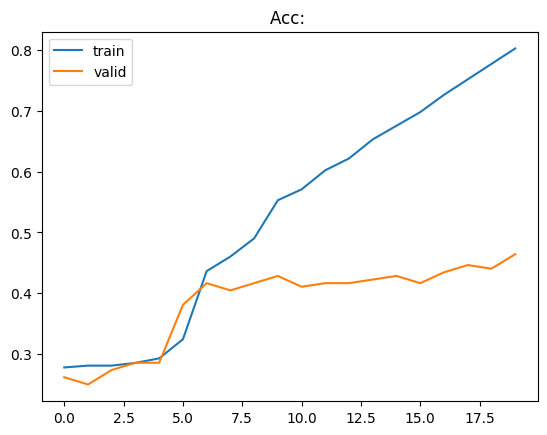

In [69]:
plt.title('Acc: ')
plt.plot(arch3_train_acc, label='train')
plt.plot(arch3_valid_acc, label='valid')
plt.legend()

Model 2 : arch 2

In [70]:
BATCH_SIZE=16
LEARNING_RATE=1e-6
EPOCHS=20
MAX_LEN = 64

In [71]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = RobertaModel.from_pretrained(model_name)
        self.act = nn.ReLU(0.2)
        self.linear_1 = nn.Linear(self.bert.config.hidden_size*2, 1024)
        self.linear_2 = nn.Linear(1024, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        last_hidden_state = self.bert(input_ids=input_id, attention_mask=mask).last_hidden_state
        mean_pooling_embeddings = torch.mean(last_hidden_state, 1)
        _, max_pooling_embeddings = torch.max(last_hidden_state, 1)
        mean_max_embeddings = torch.cat((mean_pooling_embeddings, max_pooling_embeddings), 1)
        logits = self.linear_1(mean_max_embeddings)
        logits = self.act(logits)
        logits = self.linear_2(logits)
        final_layer = self.softmax(logits)

        return final_layer

In [72]:
model = BertClassifier()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
def train(model, epochs):
    train, val = Dataset(df_train, MAX_LEN), Dataset(df_val, MAX_LEN)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)


    if use_cuda:
            print('on cuda')
            model = model.cuda()
            criterion = criterion.cuda()

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                model.zero_grad()

                output = model(input_id, mask)
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc


                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            arch4_train_acc.append(total_acc_train / len(df_train))
            arch4_valid_acc.append(total_acc_val / len(df_val))

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} \
                | Train Accuracy: {total_acc_train / len(df_train): .3f} \
                | Val Loss: {total_loss_val / len(df_val): .3f} \
                | Val Accuracy: {total_acc_val / len(df_val): .3f}')

In [74]:
print(f'Adam, BS={BATCH_SIZE}, lr={LEARNING_RATE}, ls=0.05')
print(LEARNING_RATE)
train(model, EPOCHS)

Adam, BS=16, lr=1e-06, ls=0.05
1e-06
on cuda


100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Epochs: 1 | Train Loss:  0.089                 | Train Accuracy:  0.291                 | Val Loss:  0.092                 | Val Accuracy:  0.304


100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Epochs: 2 | Train Loss:  0.089                 | Train Accuracy:  0.309                 | Val Loss:  0.093                 | Val Accuracy:  0.280


100%|██████████| 42/42 [00:55<00:00,  1.32s/it]


Epochs: 3 | Train Loss:  0.088                 | Train Accuracy:  0.306                 | Val Loss:  0.094                 | Val Accuracy:  0.280


100%|██████████| 42/42 [00:55<00:00,  1.33s/it]


Epochs: 4 | Train Loss:  0.088                 | Train Accuracy:  0.294                 | Val Loss:  0.095                 | Val Accuracy:  0.250


100%|██████████| 42/42 [00:55<00:00,  1.33s/it]


Epochs: 5 | Train Loss:  0.088                 | Train Accuracy:  0.305                 | Val Loss:  0.096                 | Val Accuracy:  0.232


100%|██████████| 42/42 [00:55<00:00,  1.32s/it]


Epochs: 6 | Train Loss:  0.087                 | Train Accuracy:  0.311                 | Val Loss:  0.094                 | Val Accuracy:  0.274


100%|██████████| 42/42 [00:54<00:00,  1.31s/it]


Epochs: 7 | Train Loss:  0.087                 | Train Accuracy:  0.318                 | Val Loss:  0.094                 | Val Accuracy:  0.238


100%|██████████| 42/42 [00:54<00:00,  1.30s/it]


Epochs: 8 | Train Loss:  0.089                 | Train Accuracy:  0.286                 | Val Loss:  0.093                 | Val Accuracy:  0.274


100%|██████████| 42/42 [00:55<00:00,  1.32s/it]


Epochs: 9 | Train Loss:  0.088                 | Train Accuracy:  0.296                 | Val Loss:  0.093                 | Val Accuracy:  0.268


100%|██████████| 42/42 [00:55<00:00,  1.32s/it]


Epochs: 10 | Train Loss:  0.085                 | Train Accuracy:  0.345                 | Val Loss:  0.092                 | Val Accuracy:  0.292


100%|██████████| 42/42 [00:56<00:00,  1.34s/it]


Epochs: 11 | Train Loss:  0.083                 | Train Accuracy:  0.395                 | Val Loss:  0.092                 | Val Accuracy:  0.280


100%|██████████| 42/42 [00:55<00:00,  1.33s/it]


Epochs: 12 | Train Loss:  0.083                 | Train Accuracy:  0.386                 | Val Loss:  0.089                 | Val Accuracy:  0.375


100%|██████████| 42/42 [4:00:59<00:00, 344.27s/it]    


Epochs: 13 | Train Loss:  0.083                 | Train Accuracy:  0.398                 | Val Loss:  0.089                 | Val Accuracy:  0.357


100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Epochs: 14 | Train Loss:  0.082                 | Train Accuracy:  0.407                 | Val Loss:  0.089                 | Val Accuracy:  0.333


100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Epochs: 15 | Train Loss:  0.082                 | Train Accuracy:  0.420                 | Val Loss:  0.089                 | Val Accuracy:  0.345


100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Epochs: 16 | Train Loss:  0.081                 | Train Accuracy:  0.429                 | Val Loss:  0.090                 | Val Accuracy:  0.327


100%|██████████| 42/42 [00:53<00:00,  1.28s/it]


Epochs: 17 | Train Loss:  0.081                 | Train Accuracy:  0.433                 | Val Loss:  0.088                 | Val Accuracy:  0.399


100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Epochs: 18 | Train Loss:  0.079                 | Train Accuracy:  0.471                 | Val Loss:  0.088                 | Val Accuracy:  0.357


100%|██████████| 42/42 [00:56<00:00,  1.35s/it]


Epochs: 19 | Train Loss:  0.079                 | Train Accuracy:  0.463                 | Val Loss:  0.087                 | Val Accuracy:  0.399


100%|██████████| 42/42 [00:57<00:00,  1.37s/it]


Epochs: 20 | Train Loss:  0.077                 | Train Accuracy:  0.505                 | Val Loss:  0.086                 | Val Accuracy:  0.411


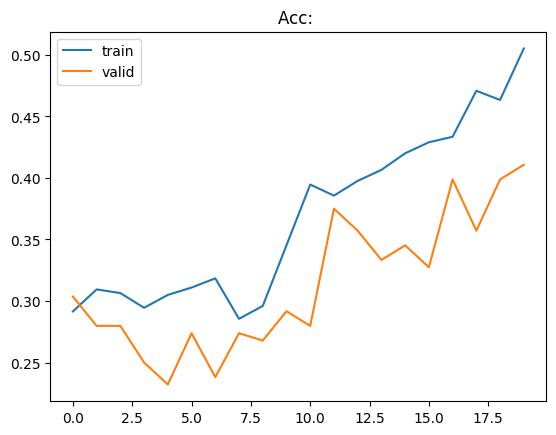

In [75]:
plt.title('Acc: ')
plt.plot(arch4_train_acc, label='train')
plt.plot(arch4_valid_acc, label='valid')
plt.legend()

----------------------

In [30]:
data = pd.read_csv('Poem_classification - test_data.csv')

In [31]:
test_df = pd.DataFrame()
test_df['text'] = data['Poem']
test_df['label'] = data['Genre']
print(new_df.shape)

(837, 2)


In [32]:
def evaluate(model, test_data):

    test = Dataset(test_data, 64)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print('Классификация текста')
    print('Персональный набор данных')
    print('Cross entropy loss, label smoothing: 0.1')
    print('AdamW', 'Learning rate: 5e-06', 'Weight decay: 1e-04', sep=", ")
    print(f'Точность: {total_acc_test * 100/ len(test_data): .2f}%')

evaluate(model, test_df)

Классификация текста
Персональный набор данных
Cross entropy loss, label smoothing: 0.1
AdamW, Learning rate: 5e-06, Weight decay: 1e-04
Точность:  14.00%
